## Imports

In [1]:
import sys
sys.path.append('src/')

import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as ticker

from dealias import VelocityDealiaser
from feature_extraction import create_downsampler, create_upsampler
from plotting import create_polar_plot, add_cbar

## Build U-Net VDA

In [2]:
start_neurons_az=16 # sn=16
vel=tf.keras.Input(shape=(None,None,1))
        
# Down portion of unet
down=create_downsampler(inp=vel,
                             start_neurons=start_neurons_az,
                             input_channels=1)
# Up portion of unet        
up=create_upsampler(n_inputs=1,
                           start_neurons=start_neurons_az,
                           n_outputs=6)

# Full model
vda = VelocityDealiaser(down,up)

# Load weights
vda.load_weights('models/dealias_sn16_csi9669.SavedModel')

2022-10-31 13:36:24.648958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 13:36:25.028439: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/dealias_sn16_csi9669.SavedModel: FAILED_PRECONDITION: models/dealias_sn16_csi9669.SavedModel; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


## Load and preprocess data
Sample `V` data extracted from NEXRAD Level 2 files are proved in pickle format for convenience in `data/`

Included in these files are 

* Level 2 `V` stored as a 4D array of shape `[1,Naz,Nrng,1]`
* Nyquist velocity with shape `[1,]`
* Level 3 `V` as a reference for "truth" with shape `[1,Naz,Nrng,1]`



In [3]:
## Load sample case
filename ='data/KLIX20210829_163916_V06.pkl'
#filename='data/KGWX20190414_041255_V06.pkl'
#filename='data/KPAH20211211_035250_V06.pkl'
with open(filename,'rb') as f:
    data = pickle.load(f)
for k in data:
    print(k,data[k].shape)

l2 (1, 720, 1152, 1)
l3 (1, 360, 1152, 1)
nyq (1,)


The U-Net is used to dealias the Level 2 data.  Before being passed to the U-Net, a few proprocessing steps need to be performed:

1.  Split the 0.5 degree data into two 1 degree arrays
2.  Pad arrays in the azimuthal dimension with periodic boundary conditions
3.  Replace bad values in the array with np.nan


In [4]:
# Preprocess data
l2=data['l2'].copy()     # [n_frames, Naz, Nrng, 1]
l3=data['l3']
nyq=data['nyq']   # [n_frames, ]

n_frames = 1 
assert l2.shape[0]==n_frames # alg only takes in 1 time frame

##  Prep data for UNet
# Add batch dim
l2=l2[None,...]
nyq=nyq[None,...]

# Split 0.5 degree data into two 1 degree arrays 
if l2.shape[2]==720:
    s=l2.shape
    l2 = np.reshape(l2,(s[0],s[1],s[2]//2,2,s[3],s[4]))
    l2 = np.transpose(l2,(0,3,1,2,4,5))
    l2 = np.reshape(l2, (2*s[0],s[1],s[2]//2,s[3],s[4]))
    nyq=np.stack((nyq,nyq))
    nyq=np.transpose(nyq,(1,0,2))
    nyq=np.reshape(nyq,(-1,n_frames,1))
    recombine=True
else:
    recombine=False
    
# Pad data 12 degrees on either side with periodic boundary conditions
pad_deg=12
l2 = np.concatenate( (l2[:,:,-pad_deg:,:,:],
                                l2,
                                l2[:,:,:pad_deg,:,:]),axis=2)  

# Replace bad values with NAN
l2[l2<=-64]=np.nan

print('vel input (batch, n_frames, Naz, Nrng, 1) =',l2.shape)   
print('nyq input (batch, n_frames, 1) =',nyq.shape)  

vel input (batch, n_frames, Naz, Nrng, 1) = (2, 1, 384, 1152, 1)
nyq input (batch, n_frames, 1) = (2, 1, 1)


## Run the U-Net VDA

The TF model returns a dict
```
{
    'dealiased_vel':   [batch, Naz, Nrng, 1]  #  dealiased velocity
    'alias_mask:      [batch, Naz, Nrng, 6]  #  raw output of U-Net
}
```

After running the VDA,  the two 1-degree arrays are recombined back into
the 0.5 degree resolution for plotting.  

In [5]:
# Run UNet
inp = {'vel':l2,'nyq':nyq}
out=vda.predict(inp)
dealiased_vel=out['dealiased_vel'].copy()

## Post process
# Recombine to 0.5 degree 
if recombine:
    s=dealiased_vel.shape
    dealiased_vel = np.reshape(dealiased_vel,(s[0]//2,2,s[1],s[2],s[3]))
    dealiased_vel = np.transpose(dealiased_vel,(0,2,1,3,4))
    dealiased_vel = np.reshape(dealiased_vel,(s[0]//2,-1,s[2],s[3]))
    
# Fix bad vals
data['l2'][data['l2']<=-64]=np.nan
l3[l3>=63.5]=np.nan

1/1 [==============================] - 1s 1s/step


## Visualize results

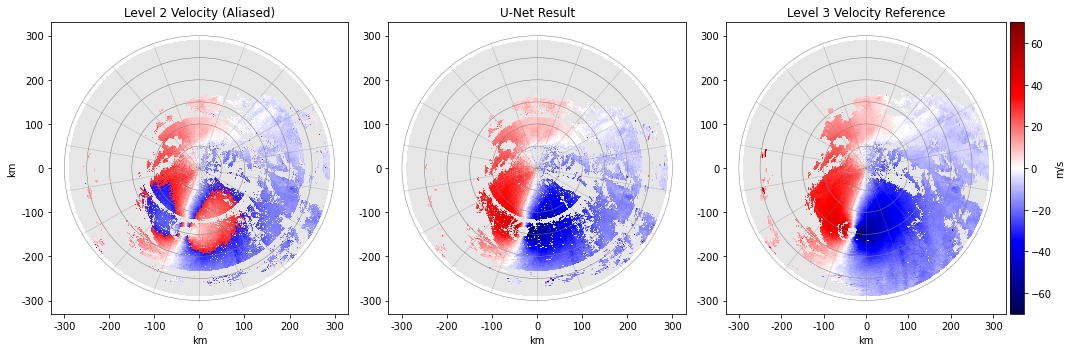

In [9]:
# Set Colormap
cmap=cm.get_cmap('seismic').copy()
cmap.set_under([.9,.9,.9])
cmap.set_bad([.9,.9,.9])
cmap.set_over([.9,.9,.9])
norm=mpl.colors.Normalize(vmin=-70, vmax=70)  


fig,axs=plt.subplots(1,3,figsize=(15,5))
im,_ = create_polar_plot(axs[0], data['l2'][0,:,:,0],cmap,norm,0.5,annotate=False)
im,_ = create_polar_plot(axs[1], out['dealiased_vel'][0,:,:,0],cmap,norm,0.5,annotate=False)
im,_ = create_polar_plot(axs[2], l3[0,:,:,0],cmap,norm,0.5,annotate=False)
add_cbar(fig,axs[2],im,'m/s')

for k,ax in enumerate(axs):
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
        ax.yaxis.set_major_formatter(ticks_y)
        ax.set_xlabel('km')
axs[0].set_ylabel('km')
axs[0].set_title('Level 2 Velocity (Aliased)')
axs[1].set_title('U-Net Result')
axs[2].set_title('Level 3 Velocity Reference')

plt.tight_layout()